In [1]:
# Imports
import os
import logging
logging.getLogger("wandb").setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

os.environ['WANDB_SILENT'] = 'true'
os.environ['WANDB_CONSOLE'] = 'off'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment, py_environment, batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
import matplotlib.pyplot as plt
import wandb

import sys
sys.path.insert(0, '..')
from environments.EnergyManagementEnv import EnergyManagementEnv
from utils.agentNetworks import ActorNetwork, CriticNetwork, CustomLayers
import utils.dataloader as DL

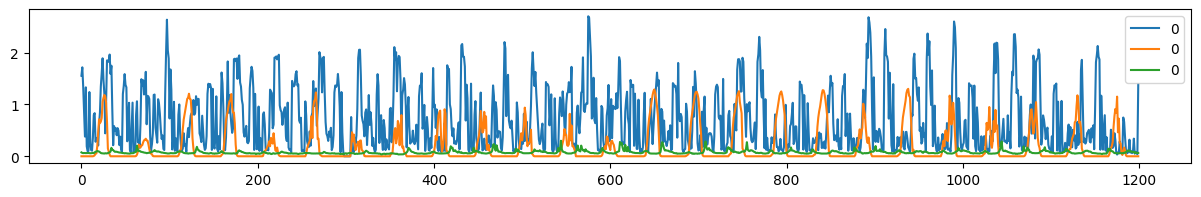

In [2]:
# Load data
# To Dos: Clean data handler (not 2 methods), scaling, no missing data at some users
num_buildings = 1
building_data = {}
path = '../../data/'
for idx in range(num_buildings):
    data_train = DL.get_customer_data(DL.loadData(path+'load1011.csv'), DL.loadPrice(path+'price_wo_outlier.csv'), customer=idx+1)
    data_eval = DL.get_customer_data(DL.loadData(path+'load1112_wo_leap.csv'), DL.loadPrice(path+'price_wo_outlier.csv'), customer=idx+1)
    data_test = DL.get_customer_data(DL.loadData(path+'load1213.csv'), DL.loadPrice(path+'price_wo_outlier.csv'), customer=idx+1)

    # Store data in the dictionary
    building_data[f"building_{idx}"] = {
        'train': {'load': data_train[0], 'pv': data_train[1], 'price': data_train[2]},
        'eval': {'load': data_eval[0], 'pv': data_eval[1], 'price': data_eval[2]},
        'test': {'load': data_test[0], 'pv': data_test[1], 'price': data_test[2]}
    }

# Plotting
fig, ax = plt.subplots(figsize=(15,2)) 
building_data[f"building_{0}"]['train']['load'][:1200].plot(label='Load', ax=ax)
building_data[f"building_{0}"]['train']['pv'][:1200].plot(label='PV', ax=ax)
building_data[f"building_{0}"]['train']['price'][:1200].plot(label='Price', ax=ax)
plt.legend()
plt.show()

In [3]:
batch_size = 64

# Assuming Battery is your custom environment
# Define your environment creation function
def create_battery_env(load_data, pv_data, price_data):
    return EnergyManagementEnv(load_data=load_data, pv_data=pv_data, price_data=price_data)

# Training environment setup
py_envs_train = [create_battery_env(building_data[f"building_{0}"]['train']['load'], building_data[f"building_{0}"]['train']['pv'], building_data[f"building_{0}"]['train']['price']) for _ in range(batch_size)]
batched_env_train = batched_py_environment.BatchedPyEnvironment(envs=py_envs_train)
tf_env_train = tf_py_environment.TFPyEnvironment(batched_env_train)


# Print
print("Batch size: ", tf_env_train.batch_size)
num_states = tf_env_train.observation_spec().shape[0]
print("Size of State Space ->  {}".format(num_states)) #SoE, price, price forecast 1-6
num_actions = tf_env_train.action_spec().shape[0]
print("Size of Action Space ->  {}".format(num_actions))
upper_bound = tf_env_train.action_spec().maximum.item()
lower_bound = tf_env_train.action_spec().minimum.item()
print("Max Value of Action ->  {}".format(upper_bound))

Batch size:  64
Size of State Space ->  6
Size of Action Space ->  1
Max Value of Action ->  2.299999952316284


In [4]:
# Setup Environments

batch_size = 32

tf_env_train = tf_py_environment.TFPyEnvironment(batched_py_environment.BatchedPyEnvironment(
    [create_battery_env(
        building_data[f"building_{0}"]['train']['load'], 
        building_data[f"building_{0}"]['train']['pv'], 
        building_data[f"building_{0}"]['train']['price']) 
        for _ in range(batch_size)]
    )
)


tf_env_eval = tf_py_environment.TFPyEnvironment(batched_py_environment.BatchedPyEnvironment(
    [create_battery_env(
        building_data[f"building_{0}"]['eval']['load'], 
        building_data[f"building_{0}"]['eval']['pv'], 
        building_data[f"building_{0}"]['eval']['price']) 
        for _ in range(batch_size)]
    )
)

tf_env_test = tf_py_environment.TFPyEnvironment(batched_py_environment.BatchedPyEnvironment(
    [create_battery_env(
        building_data[f"building_{0}"]['test']['load'], 
        building_data[f"building_{0}"]['test']['pv'], 
        building_data[f"building_{0}"]['test']['price']) 
        for _ in range(batch_size)]
    )
)

print("Batch size: ", tf_env_train.batch_size)
print("State Space: {}, Action Space: {}".format(tf_env_train.observation_spec().shape[0], tf_env_train.action_spec().shape[0])) #SoE, price, price forecast 1-6
print("Upper bound: {}".format(round(tf_env_train.action_spec().maximum.item(), 3)))

Batch size:  32
State Space: 6, Action Space: 1
Upper bound: 2.3


In [5]:
# Setup Agent networks

global_step = tf.compat.v1.train.get_or_create_global_step()

"""actor_net = ActorNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[CustomLayers.get_dense_layers(layers=1, units=4)],
    )

critic_net = CriticNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[CustomLayers.get_dense_layers(layers=1, units=4)],
    )

target_actor_network = ActorNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[CustomLayers.get_dense_layers(layers=1, units=4)],
    )

target_critic_network = CriticNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[CustomLayers.get_dense_layers(layers=1, units=4)],
    )"""

from tf_agents.agents import ddpg

actor_net = ddpg.actor_network.ActorNetwork(
    input_tensor_spec=tf_env_train.observation_spec(),
    output_tensor_spec=tf_env_train.action_spec(), fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

critic_net = ddpg.critic_network.CriticNetwork(
    input_tensor_spec=(tf_env_train.observation_spec(), tf_env_train.action_spec()),
    joint_fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

target_actor_network = ddpg.actor_network.ActorNetwork(
    input_tensor_spec=tf_env_train.observation_spec(),
    output_tensor_spec=tf_env_train.action_spec(), fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

target_critic_network = ddpg.critic_network.CriticNetwork(
    input_tensor_spec=(tf_env_train.observation_spec(), tf_env_train.action_spec()),
    joint_fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

tf_agent = ddpg_agent.DdpgAgent(
    tf_env_train.time_step_spec(),
    tf_env_train.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4), #-2 bis -4
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3), #-1 bis -3
    ou_stddev=0.2, #0.3, # 0.2 , 0.3,
    ou_damping=0.15, #0.15, #0.15,
    target_actor_network=target_actor_network,
    target_critic_network=target_critic_network,
    target_update_tau=0.05, # 0.005, 0.01, 0.05,
    target_update_period=10, # 5, 20, 50
    dqda_clipping=1,
    td_errors_loss_fn= tf.compat.v1.losses.huber_loss, #tf.keras.losses.MeanSquaredError(),
    gamma=0.99, # 0.9, 0.99
    reward_scale_factor=1, # 1.0,
    train_step_counter=global_step,
)

tf_agent.initialize()
collect_policy = tf_agent.collect_policy

In [6]:
# Initialization for training

replay_buffer_capacity = 100000
initial_collect_steps = 1000
collect_steps_per_iteration = 2000
num_iterations = 5000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=tf_env_train.batch_size,
    max_length=replay_buffer_capacity,
)

initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps,
)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration,
)

wandb.login()
wandb.init(
    project="DDPG_battery_testing",
    job_type="train_eval_test",
    name="Horizon_3h_explore",
    config={
        "train_steps": num_iterations,
        "batch_size": batch_size,
        "actor_learning_rate": 1e-3,
        "critic_learning_rate": 1e-2}
)
artifact = wandb.Artifact(name='save', type="checkpoint")

eval_metrics = [tf_metrics.AverageReturnMetric(batch_size=batch_size)]
test_metrics = [tf_metrics.AverageReturnMetric(batch_size=batch_size)]

"""train_checkpointer = common.Checkpointer(
    ckpt_dir='checkpoints/ddpg/',
    max_to_keep=1,
    agent=tf_agent,
    policy=tf_agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)
train_checkpointer.initialize_or_restore()"""

global_step = tf.compat.v1.train.get_global_step()

# For better performance
initial_collect_driver.run = common.function(initial_collect_driver.run)
collect_driver.run = common.function(collect_driver.run)
tf_agent.train = common.function(tf_agent.train)

# Collect initial replay data
initial_collect_driver.run()
time_step = tf_env_train.reset()
policy_state = collect_policy.get_initial_state(tf_env_train.batch_size)

# pipeline which will feed data to the agent
dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)
iterator = iter(dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [7]:
# Train and evaluate
print("Start training ...")
while global_step.numpy() < num_iterations:
    print(global_step.numpy(), "/ ", num_iterations)
    time_step, policy_state = collect_driver.run(
        time_step=time_step,
        policy_state=policy_state,
    )
    experience, _ = next(iterator)
    train_loss = tf_agent.train(experience)

    if global_step.numpy() % 2 == 0:
        metrics = {}    
        metrics["Loss"] = train_loss.loss
        wandb.log(metrics)

Start training ...
0 /  5000
1 /  5000
2 /  5000
3 /  5000
4 /  5000
5 /  5000
6 /  5000
7 /  5000
8 /  5000
9 /  5000
10 /  5000
11 /  5000
12 /  5000
13 /  5000
14 /  5000
15 /  5000
16 /  5000
17 /  5000
18 /  5000
19 /  5000
20 /  5000
21 /  5000
22 /  5000
23 /  5000
24 /  5000
25 /  5000
26 /  5000
27 /  5000
28 /  5000
29 /  5000
30 /  5000
31 /  5000
32 /  5000
33 /  5000
34 /  5000
35 /  5000
36 /  5000
37 /  5000
38 /  5000
39 /  5000
40 /  5000
41 /  5000
42 /  5000
43 /  5000
44 /  5000
45 /  5000
46 /  5000
47 /  5000
48 /  5000
49 /  5000
50 /  5000
51 /  5000
52 /  5000
53 /  5000
54 /  5000
55 /  5000
56 /  5000
57 /  5000
58 /  5000
59 /  5000
60 /  5000
61 /  5000
62 /  5000
63 /  5000
64 /  5000
65 /  5000
66 /  5000
67 /  5000
68 /  5000
69 /  5000
70 /  5000
71 /  5000
72 /  5000
73 /  5000
74 /  5000
75 /  5000
76 /  5000
77 /  5000
78 /  5000
79 /  5000
80 /  5000
81 /  5000
82 /  5000
83 /  5000
84 /  5000
85 /  5000
86 /  5000
87 /  5000
88 /  5000
89 /  5000
9

In [8]:
print("Start testing ...")
metrics = metric_utils.eager_compute(
    test_metrics,
    tf_env_test,
    tf_agent.policy,
    num_episodes=batch_size)
logging = {}    
logging["AverageReturn"] = metrics['AverageReturn'].numpy()
wandb.log(logging)
#artifact.add_dir(local_path='checkpoints/ddpg/')
wandb.log_artifact(artifact)

wandb.finish() #46 min

Start testing ...
